<a href="https://colab.research.google.com/github/simon-m-mudd/smm_teaching_notebooks/blob/master/get_copernicus_no_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A notebook to download and view topographic data without authentication

Simon M Mudd 15/01/2026

This allows users to download topographic data and look at a nice hillshade without using authentication. It uses the Microsoft planetary-computer interface for this purpose. It downloads COP-30 topographic data and projects it into either UTM or NSIDC polar coordinates depending on the location of the DEM.

In [1]:
!pip -q install pystac-client planetary-computer rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 6.0 MB/s eta 0:00:00


In [2]:
# If needed (uncomment):
#

from pystac_client import Client
import planetary_computer as pc
import rasterio
from rasterio.merge import merge
from rasterio.warp import transform_bounds
import numpy as np

# --- input: lower-left and upper-right as (lat, lon) ---
ll_lat, ll_lon = 56.719160975610386, -4.293183624285904
ur_lat, ur_lon = 57.2906670479597, -2.9938106687869612  # <-- change to your upper-right

# Convert to STAC bbox format: [min_lon, min_lat, max_lon, max_lat]
bbox = [min(ll_lon, ur_lon), min(ll_lat, ur_lat), max(ll_lon, ur_lon), max(ll_lat, ur_lat)]

# --- STAC search on Planetary Computer ---
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    collections=["cop-dem-glo-30"],  # Copernicus DEM GLO-30
    bbox=bbox,
)

items = list(search.items())
if not items:
    raise RuntimeError("No Copernicus DEM items found for that bounding box.")

# Sign items so the asset URLs are downloadable (adds SAS tokens)
items = [pc.sign(item) for item in items]

# Helper: get the main DEM GeoTIFF asset key robustly
def get_dem_asset(item):
    if "data" in item.assets:
        return item.assets["data"]
    # fallback: first GeoTIFF-like asset
    for k, a in item.assets.items():
        mt = (a.media_type or "").lower()
        if "geotiff" in mt or (a.href.lower().endswith((".tif", ".tiff"))):
            return a
    raise KeyError("Couldn't find a DEM GeoTIFF asset on the item.")

asset_hrefs = [get_dem_asset(it).href for it in items]

# --- Read, mosaic (if needed), and crop to your bbox ---
srcs = [rasterio.open(href) for href in asset_hrefs]
try:
    # Bounds must be in the dataset CRS for rasterio.merge.merge(bounds=...)
    dst_bounds = transform_bounds("EPSG:4326", srcs[0].crs, *bbox, densify_pts=21)

    mosaic, transform = merge(srcs, bounds=dst_bounds)

    # Convert nodata if needed (optional)
    nodata = srcs[0].nodata
    if nodata is None:
        nodata = -32768

    out_meta = srcs[0].meta.copy()
    out_meta.update(
        driver="GTiff",
        height=mosaic.shape[1],
        width=mosaic.shape[2],
        transform=transform,
        nodata=nodata,
        compress="deflate",
        tiled=True,
    )

    out_path = "copernicus_dem_glo30_clip.tif"
    with rasterio.open(out_path, "w", **out_meta) as dst:
        dst.write(mosaic)

finally:
    for s in srcs:
        s.close()

out_path


'copernicus_dem_glo30_clip.tif'

In [3]:
# If needed (uncomment):
# !pip -q install rasterio pyproj

import math
import rasterio
from rasterio.warp import (
    calculate_default_transform,
    reproject,
    transform_bounds,
    Resampling,
)

def _utm_epsg_from_lonlat(lon, lat):
    zone = int(math.floor((lon + 180) / 6) + 1)
    zone = max(1, min(zone, 60))
    return (32600 + zone) if lat >= 0 else (32700 + zone)

def reproject_dem_to_best_projected_crs(
    in_path="copernicus_dem_glo30_clip.tif",
    out_path=None,
    grid_spacing_m=30,          # default 30x30 m
    resampling="bilinear",      # good for continuous DEMs
):
    """
    Reproject DEM to:
      - EPSG:3413 if any part is north of 61N
      - EPSG:3976 if any part is south of 61S
      - else UTM zone of DEM centre point (WGS84 UTM)
    Output resolution is grid_spacing_m (square pixels).
    """
    resampling_map = {
        "nearest": Resampling.nearest,
        "bilinear": Resampling.bilinear,
        "cubic": Resampling.cubic,
        "cubic_spline": Resampling.cubic_spline,
        "lanczos": Resampling.lanczos,
        "average": Resampling.average,
        "mode": Resampling.mode,
        "max": Resampling.max,
        "min": Resampling.min,
        "med": Resampling.med,
        "q1": Resampling.q1,
        "q3": Resampling.q3,
    }
    if resampling not in resampling_map:
        raise ValueError(f"Unknown resampling='{resampling}'. Choose one of: {sorted(resampling_map)}")

    if out_path is None:
        base = in_path.rsplit(".", 1)[0]
        out_path = f"{base}_projected_{int(grid_spacing_m)}m.tif"

    with rasterio.open(in_path) as src:
        src_crs = src.crs
        if src_crs is None:
            raise ValueError("Input DEM has no CRS. Cannot decide on target projection.")

        # Get DEM bounds in lat/lon to decide north/south/UTM
        min_lon, min_lat, max_lon, max_lat = transform_bounds(
            src_crs, "EPSG:4326", *src.bounds, densify_pts=21
        )

        if max_lat > 61:
            dst_crs = "EPSG:3413"
            dst_tag = "EPSG_3413"
        elif min_lat < -61:
            dst_crs = "EPSG:3976"
            dst_tag = "EPSG_3976"
        else:
            centre_lon = (min_lon + max_lon) / 2
            centre_lat = (min_lat + max_lat) / 2
            utm_epsg = _utm_epsg_from_lonlat(centre_lon, centre_lat)
            dst_crs = f"EPSG:{utm_epsg}"
            dst_tag = f"UTM_{utm_epsg}"

        # Compute output transform/shape at requested meter resolution
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs,
            dst_crs,
            src.width,
            src.height,
            *src.bounds,
            resolution=(grid_spacing_m, grid_spacing_m),
        )

        dst_meta = src.meta.copy()
        dst_meta.update(
            crs=dst_crs,
            transform=dst_transform,
            width=dst_width,
            height=dst_height,
            compress="deflate",
            tiled=True,
        )

        with rasterio.open(out_path, "w", **dst_meta) as dst:
            for bidx in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, bidx),
                    destination=rasterio.band(dst, bidx),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=resampling_map[resampling],
                    src_nodata=src.nodata,
                    dst_nodata=src.nodata,
                )

    return {"out_path": out_path, "dst_crs": dst_crs, "dst_tag": dst_tag, "grid_spacing_m": grid_spacing_m}

# Example:
result = reproject_dem_to_best_projected_crs(
    in_path="copernicus_dem_glo30_clip.tif",
    grid_spacing_m=30
)
result


{'out_path': 'copernicus_dem_glo30_clip_projected_30m.tif',
 'dst_crs': 'EPSG:32630',
 'dst_tag': 'UTM_32630',
 'grid_spacing_m': 30}

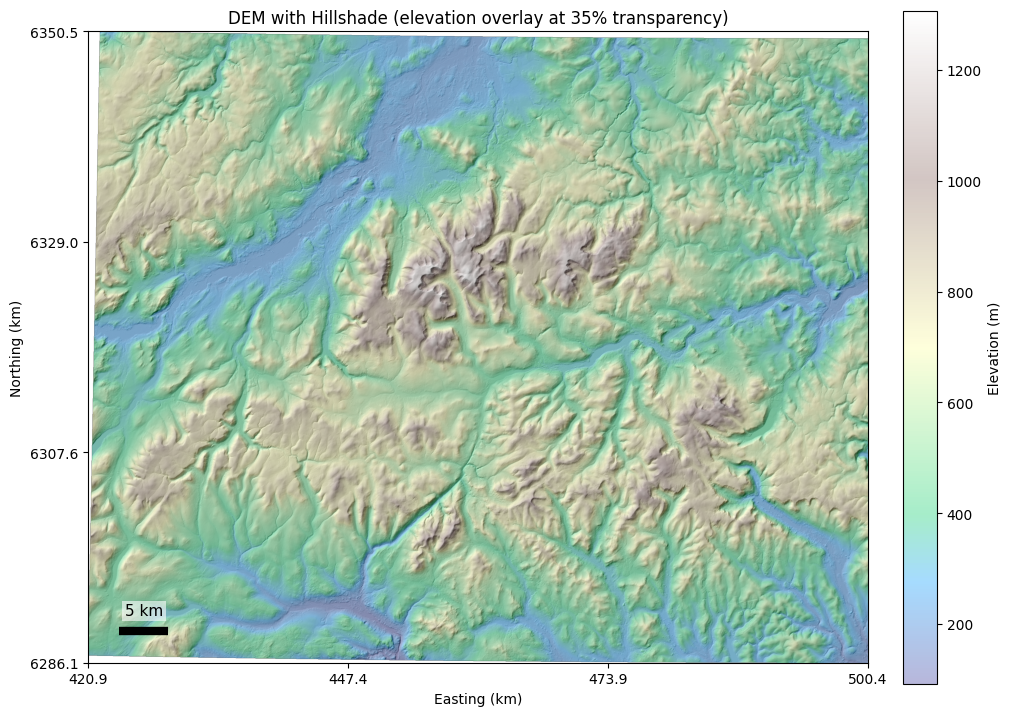

In [4]:
# If needed (uncomment):
# !pip -q install rasterio matplotlib numpy

import numpy as np
import rasterio
import matplotlib.pyplot as plt

def hillshade(elev, xres, yres, azimuth=315, altitude=45):
    """Compute hillshade from a 2D elevation array."""
    # gradients: note yres may be negative depending on transform; use abs for spacing
    dy, dx = np.gradient(elev, abs(yres), xres)
    slope = np.pi/2 - np.arctan(np.hypot(dx, dy))
    aspect = np.arctan2(-dx, dy)

    az = np.deg2rad(azimuth)
    alt = np.deg2rad(altitude)

    hs = (np.sin(alt) * np.sin(slope) +
          np.cos(alt) * np.cos(slope) * np.cos(az - aspect))
    return np.clip(hs, 0, 1)

def nice_scalebar_km(width_m, frac_min=1/20, frac_max=1/10):
    """Pick a rounded scalebar length (km) between frac_min and frac_max of plot width."""
    lo_km = (width_m * frac_min) / 1000.0
    hi_km = (width_m * frac_max) / 1000.0

    # Rounded candidates: 1, 2, 5 * 10^n (and some halves) in km
    bases = np.array([0.5, 1, 2, 5])
    candidates = []
    for n in range(-2, 6):  # 0.01 km to 500000 km (plenty)
        candidates.extend(list(bases * (10**n)))
    candidates = sorted(set(candidates))

    feasible = [c for c in candidates if lo_km <= c <= hi_km]
    if feasible:
        # choose the largest feasible rounded value (usually looks best)
        return feasible[-1]
    # fallback: clamp to nearest candidate
    nearest = min(candidates, key=lambda c: abs(c - (lo_km + hi_km) / 2))
    return nearest

# --- inputs ---
dem_path = "copernicus_dem_glo30_clip_projected_30m.tif"  # change if needed

with rasterio.open(dem_path) as src:
    z = src.read(1).astype("float32")
    nodata = src.nodata
    if nodata is not None:
        z = np.where(z == nodata, np.nan, z)

    left, bottom, right, top = src.bounds
    xres, yres = src.res  # meters (projected CRS assumed)
    width_m = right - left
    height_m = top - bottom

    hs = hillshade(z, xres=xres, yres=yres, azimuth=315, altitude=45)

# Mask NaNs for plotting
z_m = np.ma.masked_invalid(z)
hs_m = np.ma.masked_invalid(hs)

extent = [left, right, bottom, top]

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

# Hillshade base
ax.imshow(hs_m, cmap="gray", extent=extent, origin="upper")

# Elevation overlay (35% transparency)
im = ax.imshow(z_m, cmap="terrain", extent=extent, origin="upper", alpha=0.35)
cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
cbar.set_label("Elevation (m)")

# Axis labels in km
ax.set_xlabel("Easting (km)")
ax.set_ylabel("Northing (km)")

# 3–5 tick marks along each axis (use 4 by default)
nx = 4
ny = 4
xticks = np.linspace(left, right, nx)
yticks = np.linspace(bottom, top, ny)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f"{x/1000:.1f}" for x in xticks])
ax.set_yticklabels([f"{y/1000:.1f}" for y in yticks])

# --- scale bar (black bar), length 1/10 to 1/20 of DEM width with "nice" rounded km value ---
bar_km = nice_scalebar_km(width_m)
bar_m = bar_km * 1000

# Place near bottom-left with small margins
mx = 0.04 * width_m
my = 0.05 * height_m
x0 = left + mx
y0 = bottom + my

# Draw bar
ax.plot([x0, x0 + bar_m], [y0, y0], color="black", linewidth=6, solid_capstyle="butt")
# Label above center of bar
ax.text(x0 + bar_m/2, y0 + 0.02*height_m, f"{bar_km:g} km",
        ha="center", va="bottom", color="black", fontsize=11,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=2))

ax.set_title("DEM with Hillshade (elevation overlay at 35% transparency)")
plt.show()
